In [1]:
# practice with GANs!!

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def generate_sin(batch_size, seq_len):
    """Generate a batch of sine wave sequences with random phase shifts and noise."""
    x = np.linspace(0, 2 * np.pi, seq_len)
    waves = []
    for _ in range(batch_size):
        phase = np.random.uniform(0, 2 * np.pi)  # random phase shift
        y = np.sin(x + phase)  # shift the wave
        y += 0.1 * np.random.randn(seq_len)  # add noise
        waves.append(y)
    waves = np.stack(waves)  # shape: (batch_size, seq_len)
    return torch.tensor(waves, dtype=torch.float32).unsqueeze(1)  # shape: (batch_size, 1, seq_len)


In [23]:
latent_dim = 16
seq_len = 500
batch_size = 64
epochs = 20000
lr = 0.0002
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [24]:
#plot generate sin
def plot_sin(data):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.plot(data[i].numpy().flatten(), label=f'Sample {i+1}')
    plt.title('Generated Sine Waves')
    plt.xlabel('Time Step')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

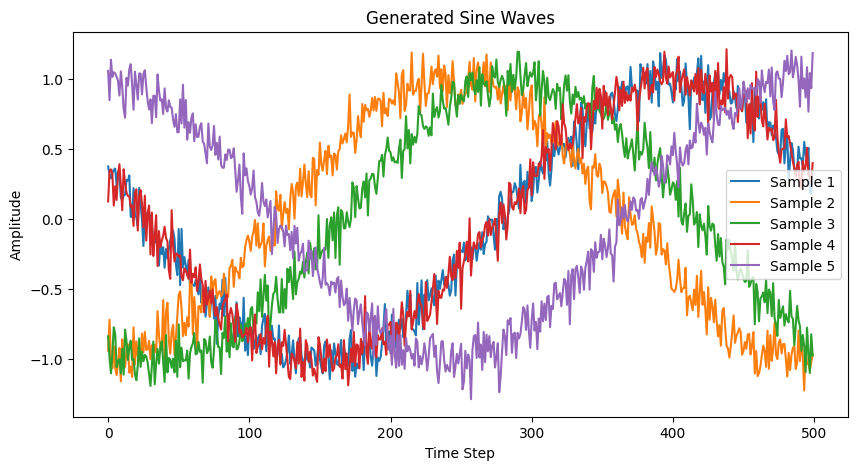

In [25]:
plot_sin(generate_sin(batch_size, seq_len))

In [26]:
class Generator(nn.Module):
    def __init__(self, latent_dim, seq_len):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.Linear(256, seq_len)

        )

    def forward(self, z):
        return self.model(z).unsqueeze(1)  # (batch, 1, seq_len)

In [27]:
class Discriminator(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(seq_len, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.view(x.size(0), -1))  # (batch, seq_len)

In [28]:
G = Generator(latent_dim, seq_len).to(device)
D = Discriminator(seq_len).to(device)
loss_fn = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=lr)
opt_D = optim.Adam(D.parameters(), lr=lr)


In [29]:
for epoch in range(epochs):
    # === Train Discriminator ===
    real_data = generate_sin(batch_size, seq_len).to(device)
    real_labels = torch.ones((batch_size, 1), device=device)
    fake_labels = torch.zeros((batch_size, 1), device=device)

    z = torch.randn(batch_size, latent_dim, device=device)
    fake_data = G(z)

    D_real = D(real_data)
    D_fake = D(fake_data.detach())

    D_loss_real = loss_fn(D_real, real_labels)
    D_loss_fake = loss_fn(D_fake, fake_labels)
    D_loss = D_loss_real + D_loss_fake

    opt_D.zero_grad()
    D_loss.backward()
    opt_D.step()

    # === Train Generator ===
    z = torch.randn(batch_size, latent_dim, device=device)
    fake_data = G(z)
    D_pred = D(fake_data)

    G_loss = loss_fn(D_pred, real_labels)  # try to trick D

    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: D_loss={D_loss.item():.4f} | G_loss={G_loss.item():.4f}")


Epoch 0: D_loss=1.4027 | G_loss=0.7189
Epoch 200: D_loss=1.0196 | G_loss=1.3723
Epoch 400: D_loss=0.8153 | G_loss=0.7623
Epoch 600: D_loss=0.5160 | G_loss=1.1381
Epoch 800: D_loss=1.4615 | G_loss=2.9652
Epoch 1000: D_loss=1.0144 | G_loss=1.9322
Epoch 1200: D_loss=0.3274 | G_loss=1.9814
Epoch 1400: D_loss=0.4055 | G_loss=1.9206
Epoch 1600: D_loss=0.7331 | G_loss=1.9684
Epoch 1800: D_loss=0.6314 | G_loss=1.8579
Epoch 2000: D_loss=0.4200 | G_loss=2.6062
Epoch 2200: D_loss=0.4960 | G_loss=1.3922
Epoch 2400: D_loss=0.8230 | G_loss=1.4116
Epoch 2600: D_loss=0.5863 | G_loss=2.0212
Epoch 2800: D_loss=0.8057 | G_loss=1.9107
Epoch 3000: D_loss=1.0388 | G_loss=1.3563
Epoch 3200: D_loss=1.1409 | G_loss=1.2010
Epoch 3400: D_loss=0.9291 | G_loss=1.1579
Epoch 3600: D_loss=1.1077 | G_loss=0.9739
Epoch 3800: D_loss=1.2963 | G_loss=0.8661
Epoch 4000: D_loss=1.5078 | G_loss=0.7159
Epoch 4200: D_loss=1.5543 | G_loss=0.7143
Epoch 4400: D_loss=1.3622 | G_loss=0.8347
Epoch 4600: D_loss=1.3693 | G_loss=0.6982

In [30]:
def plot_generated_samples(generator, latent_dim):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(5, latent_dim).to(device)
        samples = generator(z).squeeze().cpu().numpy()

    plt.figure(figsize=(10, 5))
    for i, sample in enumerate(samples):
        plt.plot(sample, label=f'Sample {i+1}')
    plt.title("Generated Sine Waves")
    plt.xlabel("Time Step")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()


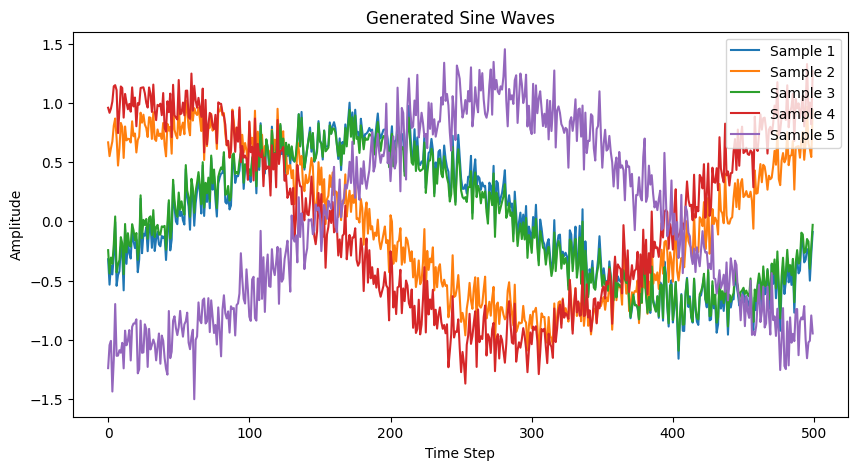

In [31]:
plot_generated_samples(G, latent_dim)
